# human MuSC moli results

In [1]:
library(miloR)
library(SingleCellExperiment)
library(scater)
library(scran)
library(dplyr)
library(patchwork)
library(zellkonverter)
library(loomR)
library(Seurat)
library(SeuratDisk)
library(data.table)

Loading required package: edgeR

Loading required package: limma

Loading required package: SummarizedExperiment

Loading required package: MatrixGenerics

Loading required package: matrixStats


Attaching package: ‘MatrixGenerics’


The following objects are masked from ‘package:matrixStats’:

    colAlls, colAnyNAs, colAnys, colAvgsPerRowSet, colCollapse,
    colCounts, colCummaxs, colCummins, colCumprods, colCumsums,
    colDiffs, colIQRDiffs, colIQRs, colLogSumExps, colMadDiffs,
    colMads, colMaxs, colMeans2, colMedians, colMins, colOrderStats,
    colProds, colQuantiles, colRanges, colRanks, colSdDiffs, colSds,
    colSums2, colTabulates, colVarDiffs, colVars, colWeightedMads,
    colWeightedMeans, colWeightedMedians, colWeightedSds,
    colWeightedVars, rowAlls, rowAnyNAs, rowAnys, rowAvgsPerColSet,
    rowCollapse, rowCounts, rowCummaxs, rowCummins, rowCumprods,
    rowCumsums, rowDiffs, rowIQRDiffs, rowIQRs, rowLogSumExps,
    rowMadDiffs, rowMads, rowMaxs, rowMeans2, rowMedi

In [2]:
adata_loom <- connect(filename = "/public/LiuTL/Rstudio/skeletal_muscle/moli_v2/data/human_SKM_v2.0_MuSC_scVI-analysis_adata_diet.loom", mode = "r+",skip.validate = TRUE)

matrix=adata_loom[["matrix"]][,]
matrix=t(matrix)
dim(matrix)

gene = adata_loom$row.attrs$var_names[]
barcode = adata_loom$col.attrs$obs_names[]
meta_data = read.csv('/public/LiuTL/Rstudio/skeletal_muscle/moli_v2/data/human_SKM_v2.0_MuSC_scVI-analysis_adata_diet_obs.csv',row.names = 1) # 这个直接给个dataframe吧
meta_feature = read.csv('/public/LiuTL/Rstudio/skeletal_muscle/moli_v2/data/human_SKM_v2.0_MuSC_scVI-analysis_adata_diet_var.csv',row.names = 1)


colnames(matrix)= barcode
row.names(matrix)= gene
x_scvi = adata_loom$col.attrs$X_scVI[,]
x_umap = adata_loom$col.attrs$X_umap[,]


seurat_object_MuSC= CreateSeuratObject(counts = matrix,meta.data = meta_data,
                                       project = 'musc_loom',
                                       min.cells = 0, 
                                       min.features = 0)

seurat_object_MuSC@assays[["RNA"]]@meta.features <- meta_feature
# seurat_object_MuSC@reductions[["scVI"]]@cell.embeddings <- x_scvi

x_scvi = t(x_scvi)
x_umap = t(x_umap)
rownames(x_scvi) = barcode
rownames(x_umap) = barcode
colnames(x_scvi) = c("scVI_1","scVI_2","scVI_3","scVI_4","scVI_5","scVI_6","scVI_7","scVI_8","scVI_9","scVI_10","scVI_11","scVI_12","scVI_13","scVI_14","scVI_15","scVI_16","scVI_17","scVI_18","scVI_19","scVI_20","scVI_21","scVI_22","scVI_23","scVI_24","scVI_25","scVI_26","scVI_27","scVI_28","scVI_29","scVI_30")
colnames(x_umap) = c('umap_1','umap_2')

Warning message in initialize(...):
“Skipping validation step, some fields are not populated”


[1] 33538 17554

Warning message:
“The following arguments are not used: row.names”


In [3]:
sce1 = as.SingleCellExperiment(seurat_object_MuSC)

sce1@int_colData@listData[["reducedDims"]]@listData[["SCVI"]] = x_scvi
sce1@int_colData@listData[["reducedDims"]]@listData[["UMAP"]] = x_umap

In [4]:
milo_obj = Milo(sce1)
milo_obj = buildGraph(milo_obj, k = 30, d = 30,reduced.dim = "SCVI")
milo_obj = makeNhoods(milo_obj, prop = 0.1, k = 30, d=30, refined = TRUE, reduced_dims = "SCVI")
milo_obj = countCells(milo_obj, meta.data = as.data.frame(colData(milo_obj)), sample="SampleID")
head(nhoodCounts(milo_obj))
summary(rowSums(nhoodCounts(milo_obj)))
sample_order = colnames(nhoodCounts(milo_obj))

exp_design <- data.frame(colData(milo_obj))[,c("SampleID","DonorID", "X10X_version", "Sex", "Age_bin")]
exp_design = distinct(exp_design)
rownames(exp_design) = exp_design$SampleID
exp_design = exp_design[sample_order,]
exp_design

milo_obj = calcNhoodDistance(milo_obj, d=30, reduced.dim = "SCVI")
da_results = testNhoods(milo_obj, design = ~ X10X_version+ Sex + Age_bin, design.df = exp_design)
head(da_results)

Constructing kNN graph with k:30

Checking valid object

Checking meta.data validity

Counting cells in neighbourhoods

   [[ suppressing 21 column names ‘mus_SNuc7468112’, ‘mus_SNuc7511880’, ‘5386STDY7600838’ ... ]]



6 x 21 sparse Matrix of class "dgCMatrix"
                                                   
1 15 1 . . 7 6 12  9 13  5  4 . .  2 8 1 6 2 1  9 5
2  . 1 3 . 4 3  3  6  .  8  3 . .  2 8 . 1 . 1  5 3
3  1 1 1 1 3 2 13  9  .  3  3 . .  1 . . . . .  . 2
4  6 7 1 3 2 1  7  .  .  9  6 . .  8 9 6 . 1 2 10 3
5  7 3 3 6 1 1  6 15  . 12  9 . .  3 1 8 . . 1  . 1
6  3 2 3 3 3 9 15 13  1 16 13 . . 11 4 4 4 1 1  2 5

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  30.00   44.00   60.00   72.76   90.00  314.00 

,SampleID,DonorID,X10X_version,Sex,Age_bin
,<chr>,<chr>,<chr>,<chr>,<chr>
mus_SNuc7468112,mus_SNuc7468112,339C,3'v2,F,2Aged
mus_SNuc7511880,mus_SNuc7511880,343B,3'v2,F,2Aged
5386STDY7600838,5386STDY7600838,362C,3'v2,M,2Aged
5386STDY7600839,5386STDY7600839,362C,3'v2,M,2Aged
5386STDY7645353,5386STDY7645353,367C,3'v2,M,2Aged
5386STDY7645354,5386STDY7645354,367C,3'v2,M,2Aged
5386STDY7835292,5386STDY7835292,411C,3'v2,M,1Young
5386STDY7835293,5386STDY7835293,411C,3'v2,M,1Young
5386STDY8047212,5386STDY8047212,464C,3'v2,M,1Young


as(<dgTMatrix>, "dgCMatrix") is deprecated since Matrix 1.5-0; do as(., "CsparseMatrix") instead

Using TMM normalisation

Performing spatial FDR correction withk-distance weighting



,logFC,logCPM,F,PValue,FDR,Nhood,SpatialFDR
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,-0.6151780,10.608149,0.82187904,0.3646398,0.7463176,1,0.7506448
2,0.1711517,9.928812,0.05571954,0.8133958,0.9483576,2,0.9499596
3,-0.4308521,9.643628,0.30093284,0.5833029,0.8647805,3,0.8685020
4,-0.4448963,10.366317,0.35478711,0.5514209,0.8467344,4,0.8506618
5,-0.6202317,10.222678,0.67785974,0.4103322,0.7808561,5,0.7857046
6,-0.4699855,10.594713,0.52122712,0.4703252,0.8187121,6,0.8235602


In [5]:
save.image('./write/human_SKM_v2_MuSC_moli_v3_r_2.RData')

In [6]:
da_results %>%
  arrange(SpatialFDR) %>%
  head() 

,logFC,logCPM,F,PValue,FDR,Nhood,SpatialFDR
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1066,-5.754997,10.512769,22.09258,2.611415e-06,0.003995465,1066,0.003872597
47,-5.696157,10.203502,20.39094,6.340500e-06,0.004204474,47,0.004129521
709,-4.518583,11.019457,19.88839,8.244067e-06,0.004204474,709,0.004129521
978,-3.789880,10.729753,17.27375,3.246611e-05,0.012418287,978,0.011993364
52,-3.539015,10.573325,14.65375,1.294799e-04,0.024763037,52,0.025145947
85,-4.929727,9.836082,14.73766,1.238461e-04,0.024763037,85,0.025145947


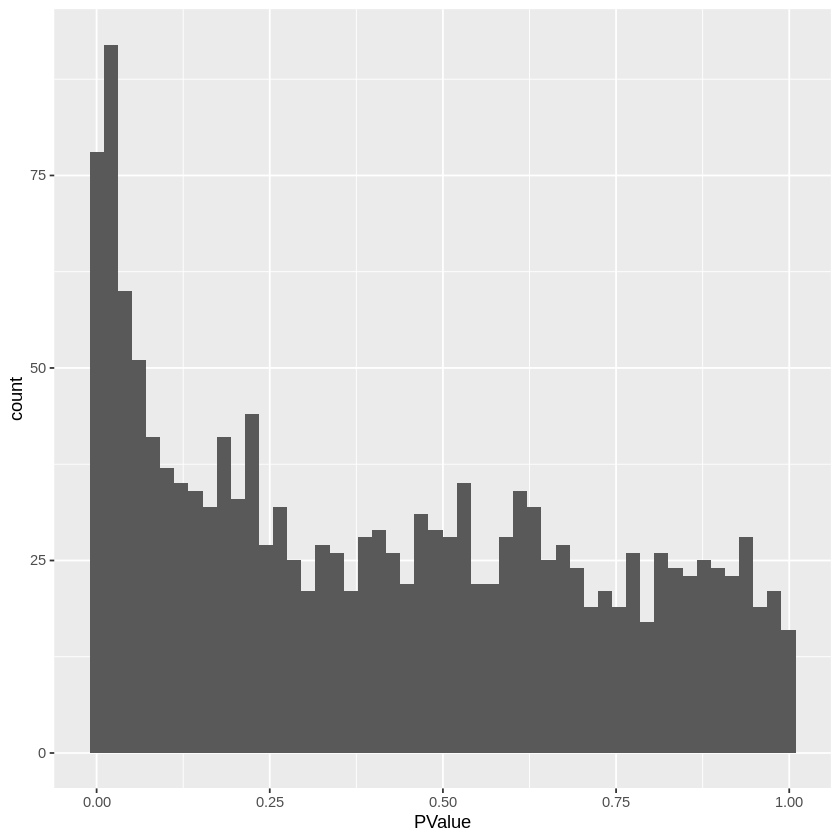

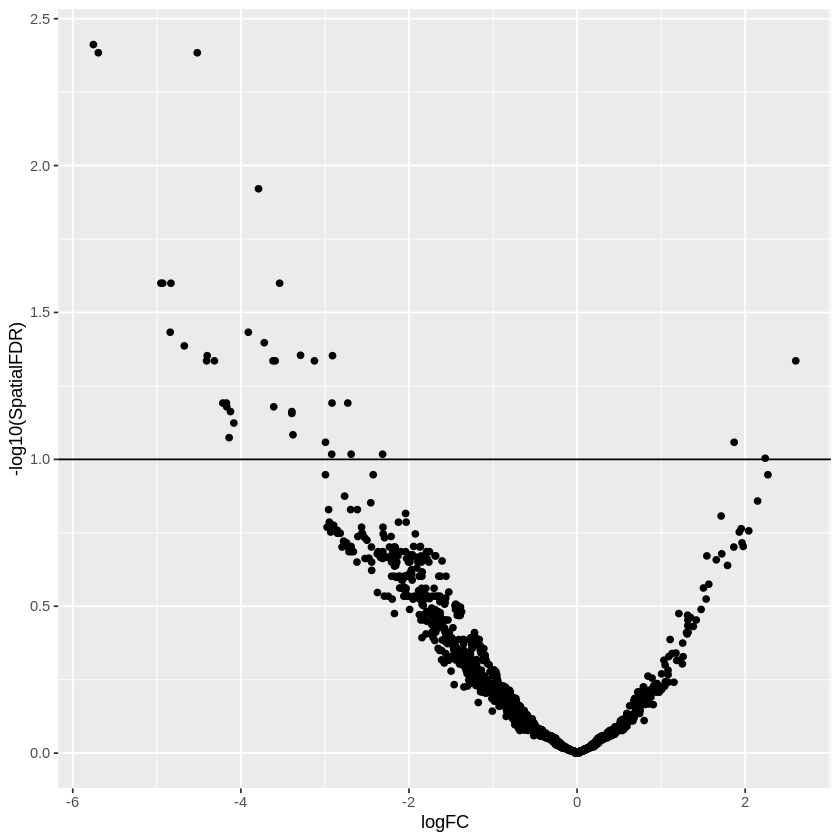

In [7]:
ggplot(da_results, aes(PValue)) + geom_histogram(bins=50)
ggplot(da_results, aes(logFC, -log10(SpatialFDR))) + geom_point() +  geom_hline(yintercept = 1) 

In [8]:
milo_obj = buildNhoodGraph(milo_obj)
colData(milo_obj)

DataFrame with 17554 rows and 55 columns
                                  orig.ident nCount_RNA nFeature_RNA
                                    <factor>  <numeric>    <integer>
mus_SNuc7468112-AACTCAGCAAGAAGAG   musc_loom      28646         4863
mus_SNuc7468112-GGATGTTCAGTAGAGC   musc_loom      27223         4836
mus_SNuc7468112-CAGCGACTCACTGGGC   musc_loom      10569         2706
mus_SNuc7468112-AACTGGTTCTGGTTCC   musc_loom       9705         2753
mus_SNuc7468112-TCTATTGGTTCATGGT   musc_loom       9508         2784
...                                      ...        ...          ...
WS_A_SKM10490128-TTGTTTGAGCTCTGTA  musc_loom        942          545
WS_A_SKM10490128-TTTGGAGTCGCGCCAA  musc_loom        909          531
WS_A_SKM10490128-CCGCAAGGTCGTATTG  musc_loom        887          512
WS_A_SKM10490128-GTTACAGAGGATTTAG  musc_loom        887          585
WS_A_SKM10490128-TACCCACTCATCTCTA  musc_loom        860          529
                                          SampleID          ba

Scale for 'fill' is already present. Adding another scale for 'fill', which
will replace the existing scale.



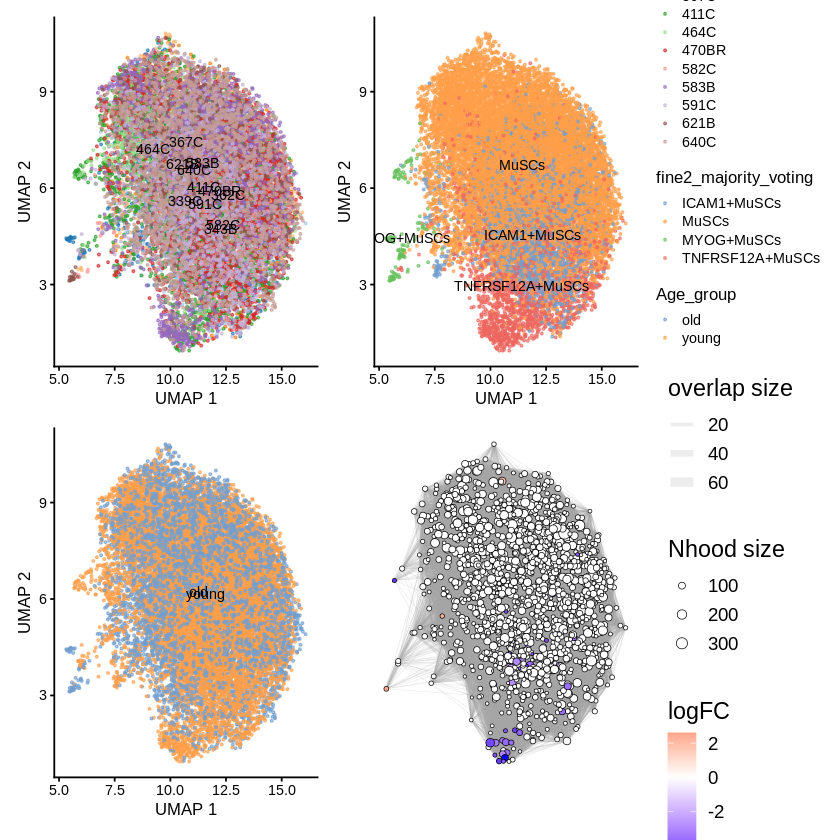

In [9]:
## Plot single-cell UMAP
umap_pl1 <- plotReducedDim(milo_obj, dimred = "UMAP", colour_by="DonorID", text_by = "DonorID", text_size = 3, point_size=0.5) +  guides(fill="none")
umap_pl2 <- plotReducedDim(milo_obj, dimred = "UMAP", colour_by="fine2_majority_voting", text_by = "fine2_majority_voting", text_size = 3, point_size=0.5) +  guides(fill="none")
umap_pl3 <- plotReducedDim(milo_obj, dimred = "UMAP", colour_by="Age_group", text_by = "Age_group", text_size = 3, point_size=0.5) +  guides(fill="none")

# str(milo_obj)
## Plot neighbourhood graph
nh_graph_pl <- plotNhoodGraphDA(milo_obj, da_results, layout="UMAP",alpha=0.1) + scale_fill_gradient2(name = "logFC", low = "blue", high = "red") 

nh_plt_comb = umap_pl1+umap_pl2+umap_pl3 + nh_graph_pl + plot_layout(guides="collect")
nh_plt_comb

In [10]:
ggsave(filename = "./figure/human_SKM_v2_MuSC_moli_v3_r_1.png", plot = nh_plt_comb, width = 10, height = 10)

In [11]:
da_results <- annotateNhoods(milo_obj, da_results, coldata_col = "fine2_majority_voting")
head(da_results)

Converting fine2_majority_voting to factor...



,logFC,logCPM,F,PValue,FDR,Nhood,SpatialFDR,fine2_majority_voting,fine2_majority_voting_fraction
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>
1,-0.6151780,10.608149,0.82187904,0.3646398,0.7463176,1,0.7506448,MuSCs,0.9433962
2,0.1711517,9.928812,0.05571954,0.8133958,0.9483576,2,0.9499596,MuSCs,0.9411765
3,-0.4308521,9.643628,0.30093284,0.5833029,0.8647805,3,0.8685020,MuSCs,0.9500000
4,-0.4448963,10.366317,0.35478711,0.5514209,0.8467344,4,0.8506618,MuSCs,0.7160494
5,-0.6202317,10.222678,0.67785974,0.4103322,0.7808561,5,0.7857046,MuSCs,0.7272727
6,-0.4699855,10.594713,0.52122712,0.4703252,0.8187121,6,0.8235602,MuSCs,0.9292035


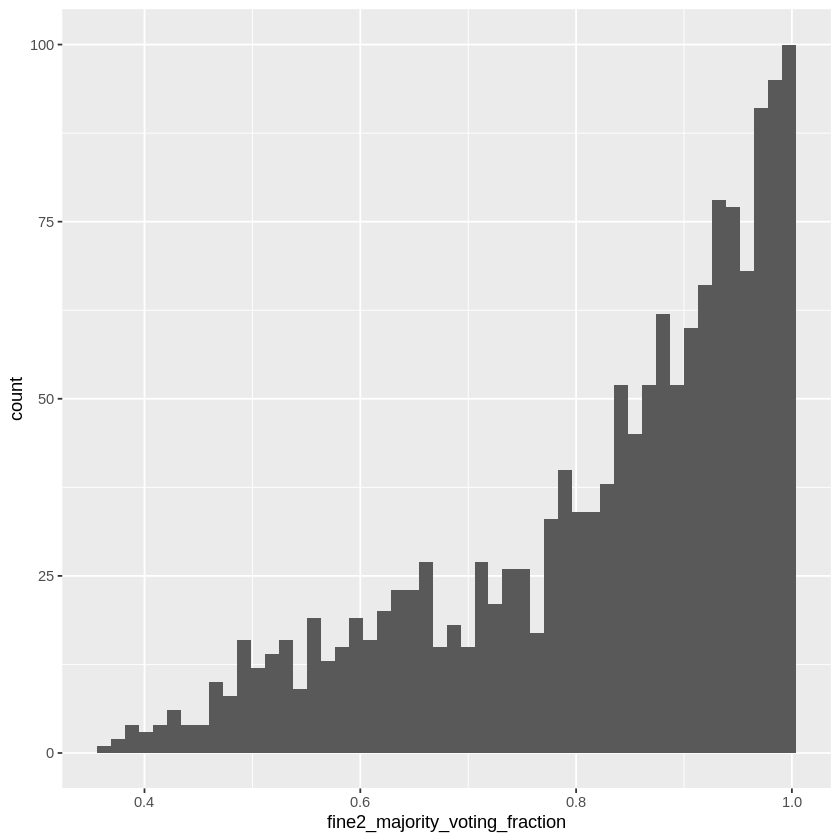

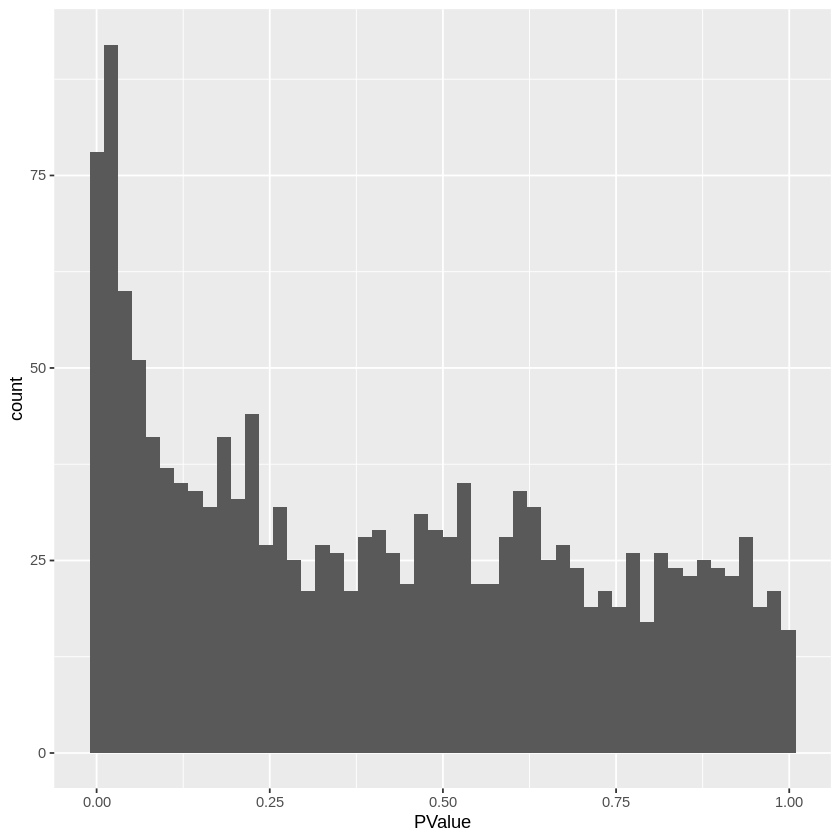

In [12]:
ggplot(da_results, aes(fine2_majority_voting_fraction)) + geom_histogram(bins=50)
ggplot(da_results, aes(PValue)) + geom_histogram(bins=50)

In [28]:
# if da_results$fine2_majority_voting_fraction < 0.7, ICA+ MuSC = 2
da_results$fine2_majority_voting_clean <- ifelse(da_results$fine2_majority_voting_fraction < 0.7, "Mixed", da_results$fine2_majority_voting)
table(da_results$fine2_majority_voting_clean)


    ICAM1+MuSCs           Mixed           MuSCs      MYOG+MuSCs TNFRSF12A+MuSCs 
              2             328            1164               3              33 

In [20]:
# if da_results$fine2_majority_voting_fraction < 0.5, ICA+ MuSC = 13
da_results$fine2_majority_voting_clean <- ifelse(da_results$fine2_majority_voting_fraction < 0.5, "Mixed", da_results$fine2_majority_voting)
table(da_results$fine2_majority_voting_clean)


    ICAM1+MuSCs           Mixed           MuSCs      MYOG+MuSCs TNFRSF12A+MuSCs 
             13              62            1372               6              77 

In [ ]:
# those result is based on da_results$fine2_majority_voting_fraction < 0.7

In [29]:
head(da_results)

,logFC,logCPM,F,PValue,FDR,Nhood,SpatialFDR,fine2_majority_voting,fine2_majority_voting_fraction,fine2_majority_voting_clean
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<chr>
1,-0.6151780,10.608149,0.82187904,0.3646398,0.7463176,1,0.7506448,MuSCs,0.9433962,MuSCs
2,0.1711517,9.928812,0.05571954,0.8133958,0.9483576,2,0.9499596,MuSCs,0.9411765,MuSCs
3,-0.4308521,9.643628,0.30093284,0.5833029,0.8647805,3,0.8685020,MuSCs,0.9500000,MuSCs
4,-0.4448963,10.366317,0.35478711,0.5514209,0.8467344,4,0.8506618,MuSCs,0.7160494,MuSCs
5,-0.6202317,10.222678,0.67785974,0.4103322,0.7808561,5,0.7857046,MuSCs,0.7272727,MuSCs
6,-0.4699855,10.594713,0.52122712,0.4703252,0.8187121,6,0.8235602,MuSCs,0.9292035,MuSCs


In [30]:
cell_type = c('MYOG+MuSCs','ICAM1+MuSCs','TNFRSF12A+MuSCs','MuSCs')

In [32]:
da_results$fine2_majority_voting_clean <- factor(da_results$fine2_majority_voting_clean, levels=cell_type, ordered=TRUE)

In [33]:
library(ggbeeswarm)

In [34]:
da_results_clean1 = da_results[da_results$fine2_majority_voting_clean %in% cell_type,]

Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.



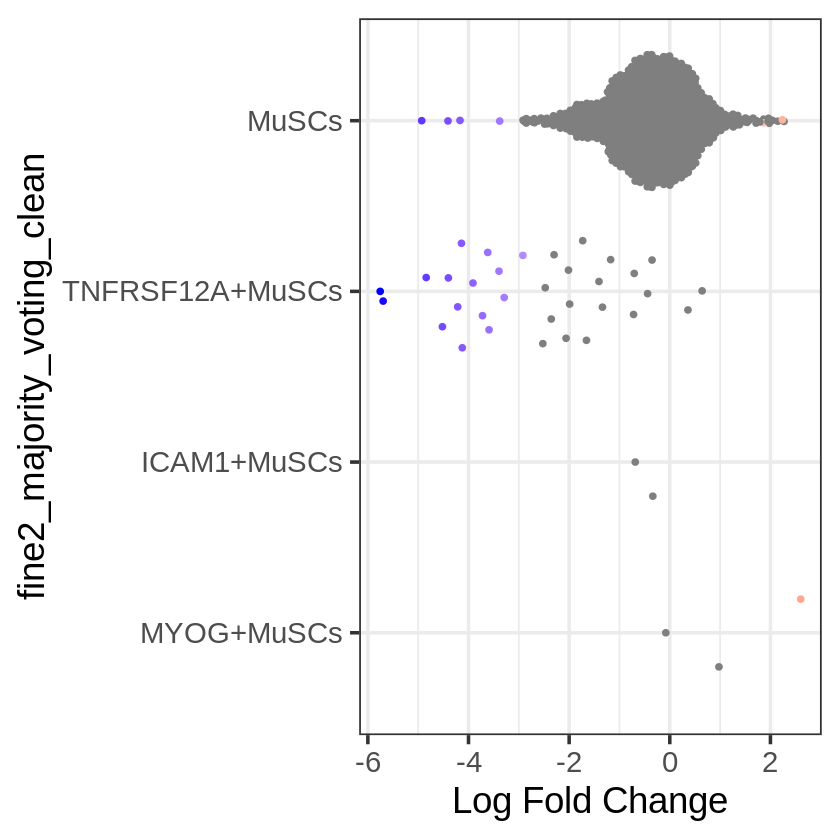

In [35]:
difab_plot = plotDAbeeswarm(da_results_clean1, group.by ="fine2_majority_voting_clean") +scale_color_gradient2(low = ("blue"), high = ("red"))
difab_plot

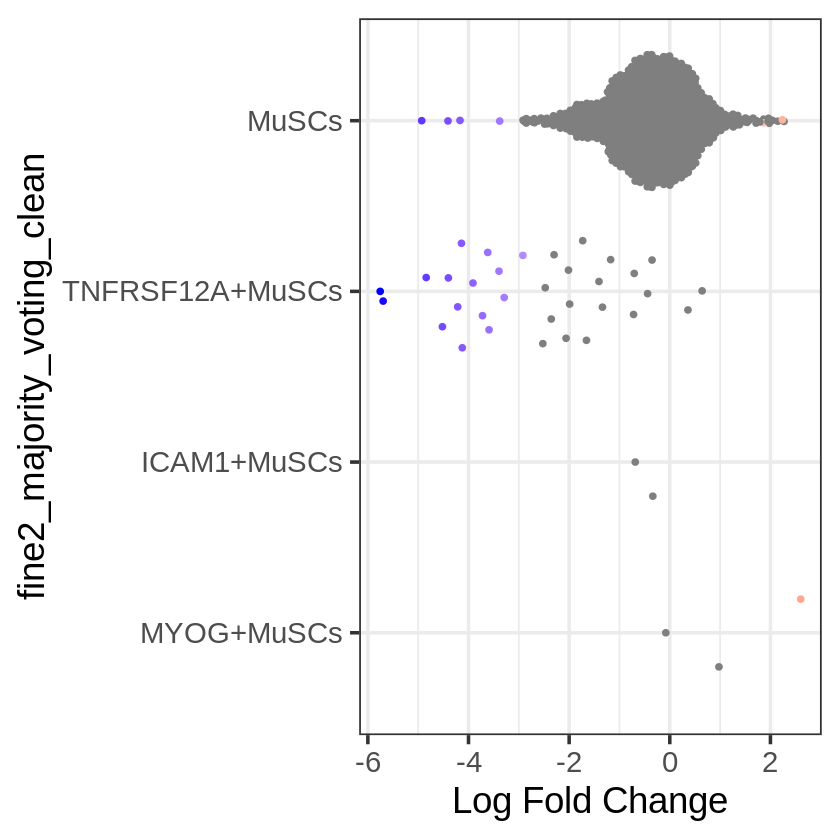

In [49]:
difab_plot
ggsave(filename = paste0(figures_path, "human_SKM_v2_Immune_moli_v3_r_Donorfilt.pdf"), plot = difab_plot, width = 6, height = 5)

Code to remove Donor specific neughbourhoods

In [31]:
da_results2 <- annotateNhoods(milo_obj, da_results, coldata_col = "DonorID")
head(da_results2)

Converting DonorID to factor...



,logFC,logCPM,F,PValue,FDR,Nhood,SpatialFDR,fine2_majority_voting,fine2_majority_voting_fraction,fine2_majority_voting_clean,DonorID,DonorID_fraction
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<chr>,<chr>,<dbl>
1,-0.6151780,10.608149,0.82187904,0.3646398,0.7463176,1,0.7506448,MuSCs,0.9433962,MuSCs,411C,0.1981132
2,0.1711517,9.928812,0.05571954,0.8133958,0.9483576,2,0.9499596,MuSCs,0.9411765,MuSCs,470BR,0.2156863
3,-0.4308521,9.643628,0.30093284,0.5833029,0.8647805,3,0.8685020,MuSCs,0.9500000,MuSCs,411C,0.5500000
4,-0.4448963,10.366317,0.35478711,0.5514209,0.8467344,4,0.8506618,MuSCs,0.7160494,MuSCs,583B,0.2098765
5,-0.6202317,10.222678,0.67785974,0.4103322,0.7808561,5,0.7857046,MuSCs,0.7272727,MuSCs,411C,0.2727273
6,-0.4699855,10.594713,0.52122712,0.4703252,0.8187121,6,0.8235602,MuSCs,0.9292035,MuSCs,470BR,0.2566372


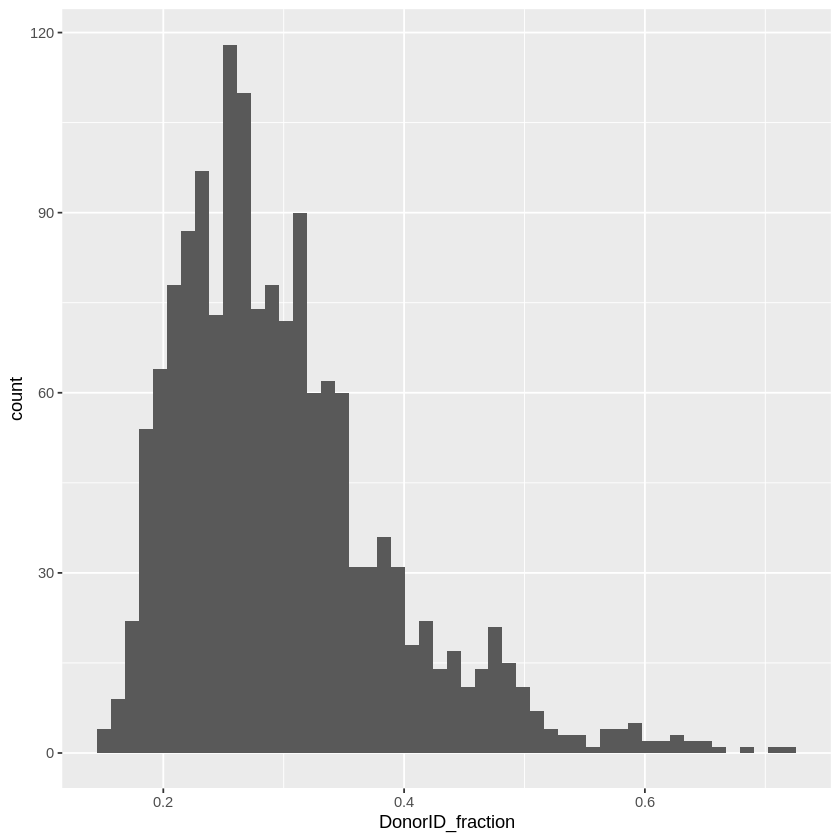

In [36]:
ggplot(da_results2, aes(DonorID_fraction)) + geom_histogram(bins=50)

Plot distribution of max donor percentage across significant neighbourhoods

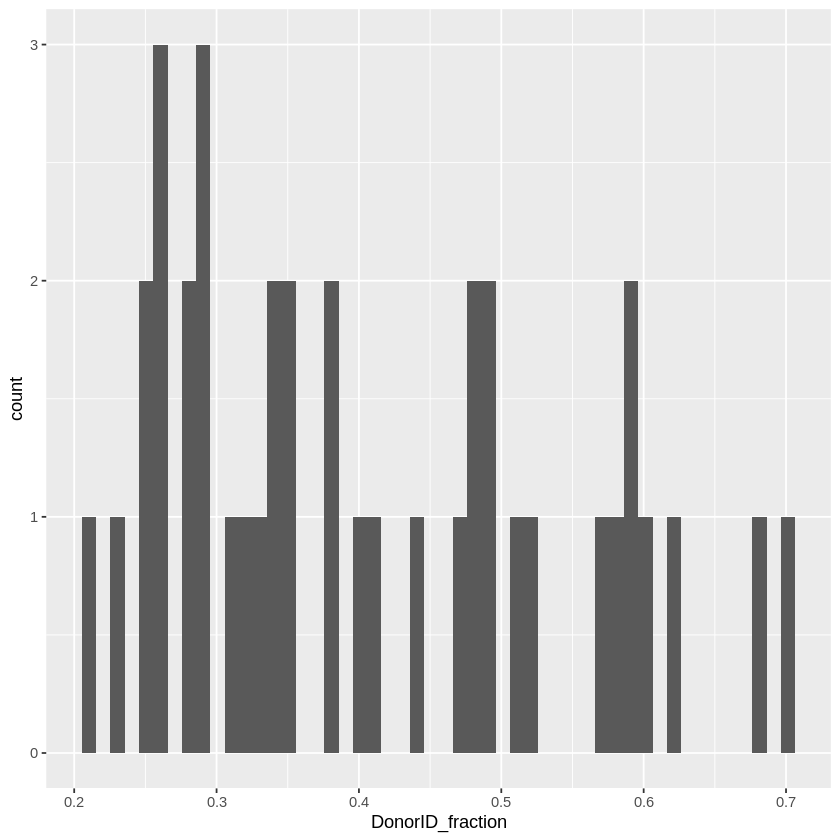

In [37]:
ggplot(da_results2[da_results2$SpatialFDR<0.1,], aes(DonorID_fraction)) + geom_histogram(bins=50)

In [38]:
head(da_results2)

,logFC,logCPM,F,PValue,FDR,Nhood,SpatialFDR,fine2_majority_voting,fine2_majority_voting_fraction,fine2_majority_voting_clean,DonorID,DonorID_fraction
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<chr>,<chr>,<dbl>
1,-0.6151780,10.608149,0.82187904,0.3646398,0.7463176,1,0.7506448,MuSCs,0.9433962,MuSCs,411C,0.1981132
2,0.1711517,9.928812,0.05571954,0.8133958,0.9483576,2,0.9499596,MuSCs,0.9411765,MuSCs,470BR,0.2156863
3,-0.4308521,9.643628,0.30093284,0.5833029,0.8647805,3,0.8685020,MuSCs,0.9500000,MuSCs,411C,0.5500000
4,-0.4448963,10.366317,0.35478711,0.5514209,0.8467344,4,0.8506618,MuSCs,0.7160494,MuSCs,583B,0.2098765
5,-0.6202317,10.222678,0.67785974,0.4103322,0.7808561,5,0.7857046,MuSCs,0.7272727,MuSCs,411C,0.2727273
6,-0.4699855,10.594713,0.52122712,0.4703252,0.8187121,6,0.8235602,MuSCs,0.9292035,MuSCs,470BR,0.2566372


In [39]:
da_results2$annotation_level1_clean = da_results2$fine2_majority_voting_clean
da_results2$annotation_level1_clean2 <- ifelse(da_results2$DonorID_fraction > 0.9, "Donor-specific", da_results2$annotation_level1_clean)
head(da_results2)

,logFC,logCPM,F,PValue,FDR,Nhood,SpatialFDR,fine2_majority_voting,fine2_majority_voting_fraction,fine2_majority_voting_clean,DonorID,DonorID_fraction,annotation_level1_clean,annotation_level1_clean2
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<chr>,<chr>,<dbl>,<chr>,<chr>
1,-0.6151780,10.608149,0.82187904,0.3646398,0.7463176,1,0.7506448,MuSCs,0.9433962,MuSCs,411C,0.1981132,MuSCs,MuSCs
2,0.1711517,9.928812,0.05571954,0.8133958,0.9483576,2,0.9499596,MuSCs,0.9411765,MuSCs,470BR,0.2156863,MuSCs,MuSCs
3,-0.4308521,9.643628,0.30093284,0.5833029,0.8647805,3,0.8685020,MuSCs,0.9500000,MuSCs,411C,0.5500000,MuSCs,MuSCs
4,-0.4448963,10.366317,0.35478711,0.5514209,0.8467344,4,0.8506618,MuSCs,0.7160494,MuSCs,583B,0.2098765,MuSCs,MuSCs
5,-0.6202317,10.222678,0.67785974,0.4103322,0.7808561,5,0.7857046,MuSCs,0.7272727,MuSCs,411C,0.2727273,MuSCs,MuSCs
6,-0.4699855,10.594713,0.52122712,0.4703252,0.8187121,6,0.8235602,MuSCs,0.9292035,MuSCs,470BR,0.2566372,MuSCs,MuSCs


In [40]:
table(da_results2$annotation_level1_clean2)


    ICAM1+MuSCs           Mixed           MuSCs      MYOG+MuSCs TNFRSF12A+MuSCs 
              2             328            1164               3              33 

In [41]:
da_results2$annotation_level1_clean2 = factor(da_results2$annotation_level1_clean2, levels = 
                                             c(cell_type,'Mixed'))

In [42]:
figures_path = './figure/'
tables_path = './table/'

In [43]:
da_results2_clean1 = da_results2[da_results2$annotation_level1_clean2 %in% cell_type,]

Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.

Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.



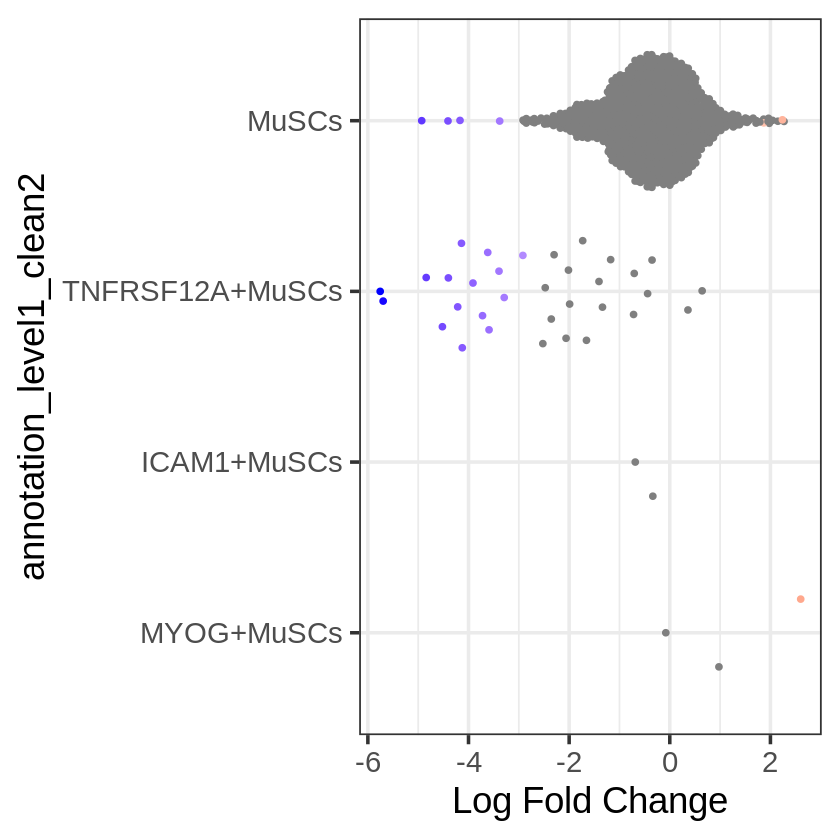

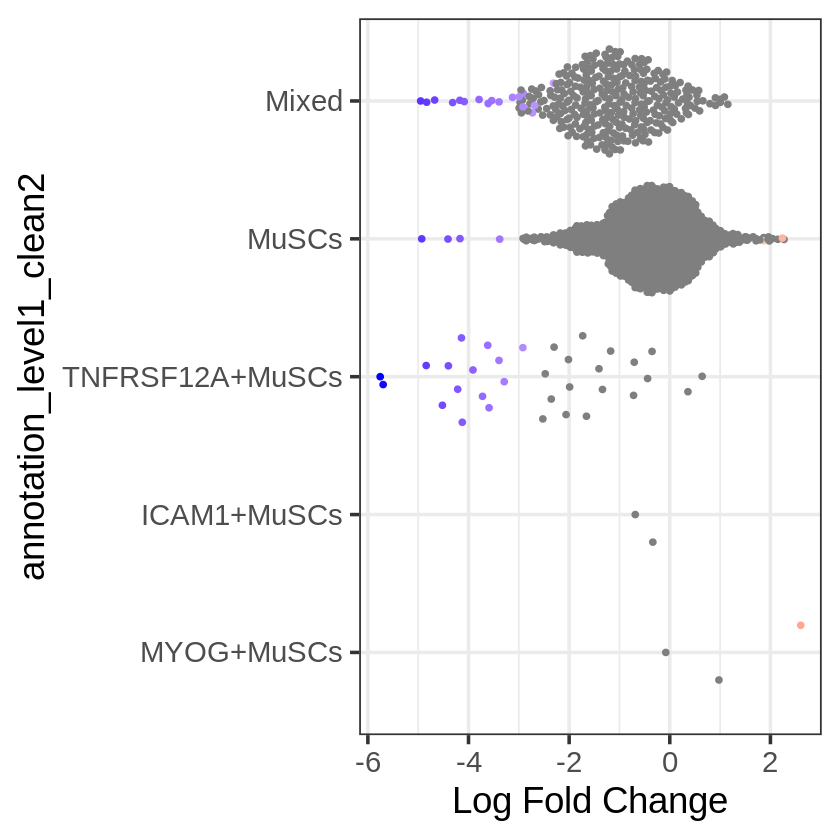

In [50]:
difab_plot_rm = plotDAbeeswarm(da_results2_clean1,  
                            group.by ="annotation_level1_clean2") +scale_color_gradient2(low = ("blue"), high = ("red"))
difab_plot_rm
ggsave(filename = paste0(figures_path, "human_SKM_v2_MuSC_moli_v3_r_Donorfilt.pdf"), plot = difab_plot_rm, width = 6, height = 5)

difab_plot_all = plotDAbeeswarm(da_results2, group.by ="annotation_level1_clean2") +scale_color_gradient2(low = ("blue"), high = ("red")) 
difab_plot_all
ggsave(filename = paste0(figures_path, "human_SKM_v2_MuSC_moli_v3_r_all.pdf"), plot = difab_plot_all, width = 6, height = 5)

In [51]:
library('ggplot2')
library(scales)

Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.



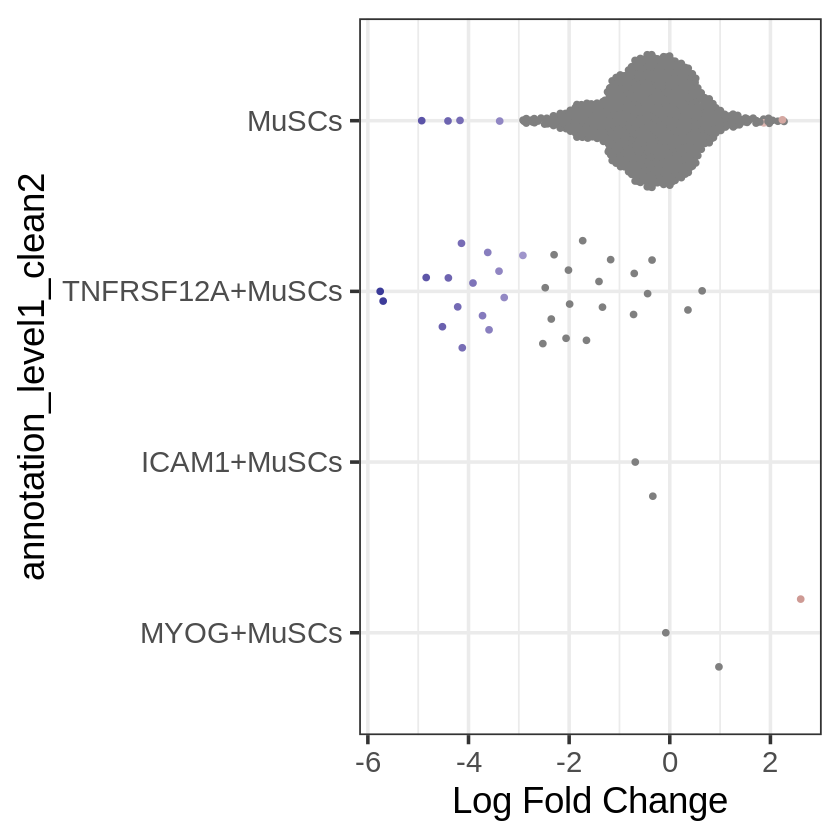

In [54]:
difab_plot_rm = plotDAbeeswarm(da_results2_clean1,  
                            group.by ="annotation_level1_clean2") +scale_color_gradient2(low = muted("blue"), high = muted("red"))
difab_plot_rm
ggsave(filename = paste0(figures_path, "human_SKM_v2_MuSC_moli_v3_r_Donorfilt_v2.pdf"), plot = difab_plot_rm, width = 6, height = 5)

Change LogFC to 0 for Donor-specific and Mixed neighbourhoods (won't be displayed on umap)

In [45]:
da_results2$logFC2 = ifelse(da_results2$annotation_level1_clean2 %in% c('Mixed'), 0, da_results2$logFC)

In [46]:
milo_obj = buildNhoodGraph(milo_obj)

Scale for 'fill' is already present. Adding another scale for 'fill', which
will replace the existing scale.



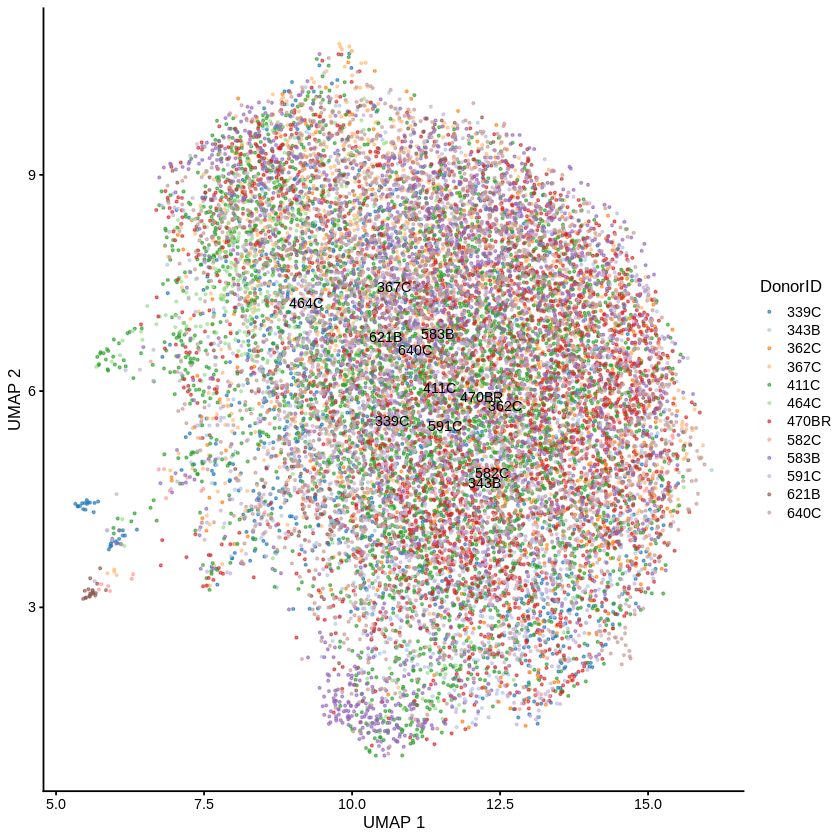

Scale for 'fill' is already present. Adding another scale for 'fill', which
will replace the existing scale.



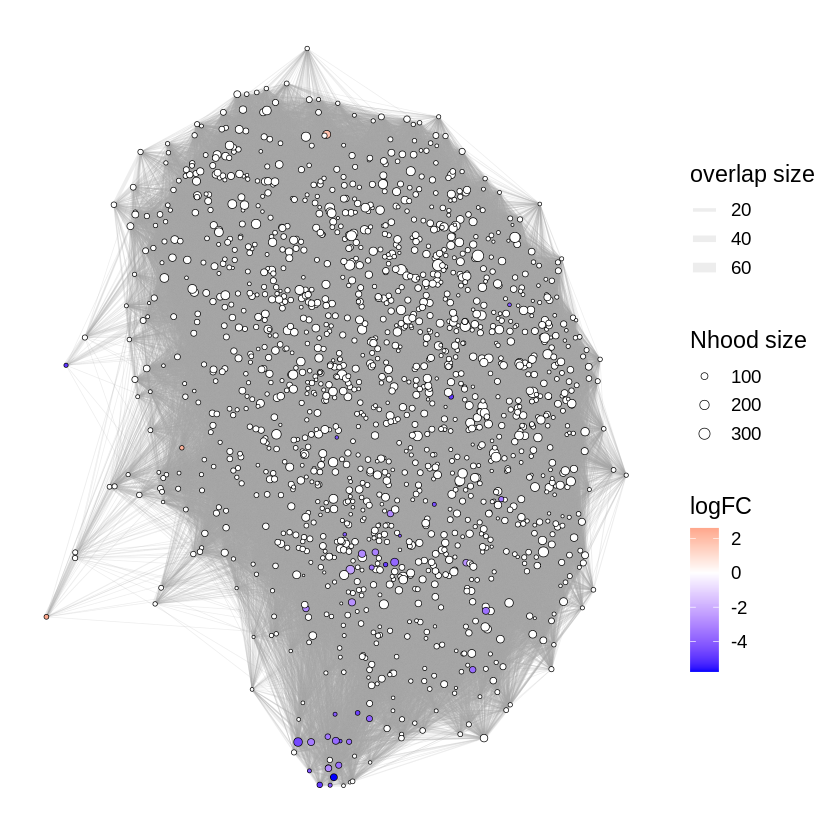

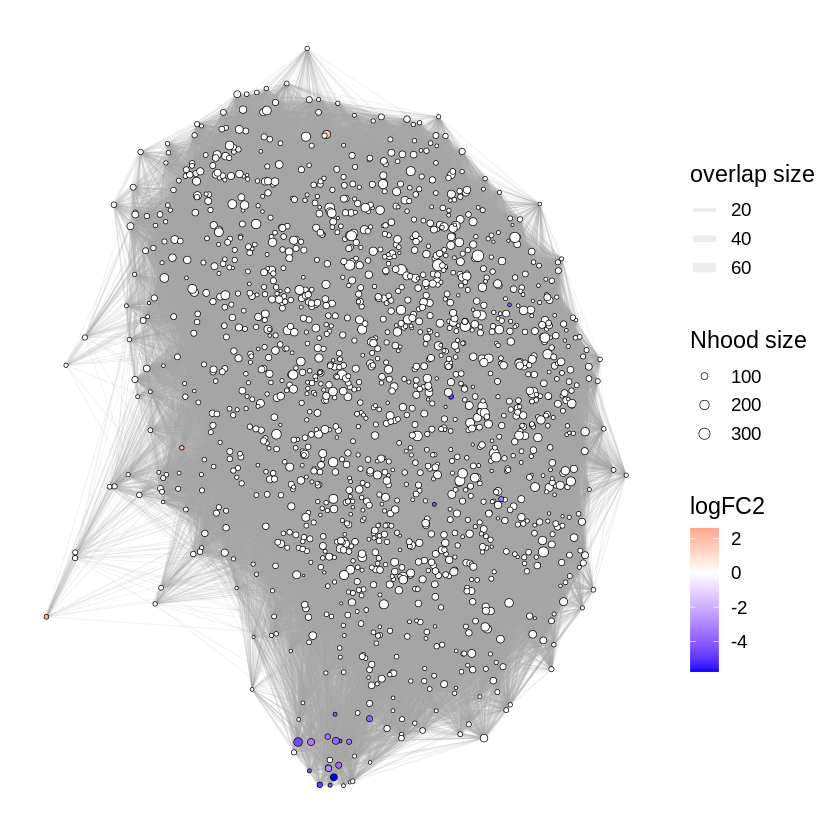

In [47]:
umap_pl <- plotReducedDim(milo_obj, dimred = "UMAP", colour_by="DonorID", 
                           text_by = "DonorID",text_size = 3, point_size=0.5) +
  guides(fill="none")
umap_pl

ggsave(paste0(figures_path, "human_SKM_v2_MuSC_moli_v3_rdonor.pdf"), umap_pl, width = 4, height = 3.5)
## plot neighbourhood graph highlighting nhds with significant chnages 
## (Donor-specific and mixed populations are kept in)
nh_graph_pl1 <- plotNhoodGraphDA(milo_obj, da_results2, layout="UMAP",alpha=0.1) + 
scale_fill_gradient2(name = "logFC", low = ("blue"), high = ("red")) 
nh_graph_pl1
ggsave(paste0(figures_path, "human_SKM_v2_MuSC_moli_v3_r_nhds.pdf"), nh_graph_pl1, width = 4, height = 3.5)
ggsave(paste0(figures_path, "human_SKM_v2_MuSC_moli_v3_r_nhds.png"), nh_graph_pl1, width = 4, height = 3.5)
## plot neighbourhood graph highlighting nhds with significant chnages 
## (Donor-specific and mixed populations are removed)
nh_graph_pl2 <- plotNhoodGraphDA(milo_obj, da_results2, layout="UMAP",alpha=0.1, res_column = "logFC2") + 
scale_fill_gradient2(name = "logFC2", low = ("blue"), high = ("red"))

nh_graph_pl2
ggsave(paste0(figures_path, "human_SKM_v2_MuSC_moli_v3_r_nhds_filt.pdf"), nh_graph_pl2, width = 4, height = 3.5)
ggsave(paste0(figures_path, "human_SKM_v2_MuSC_moli_v3_r_nhds_filt.png"), nh_graph_pl2, width = 4, height = 3.5)
#nh_plt_comb = umap_pl + nh_graph_pl1 +nh_graph_pl2
#  plot_layout(guides="collect")

In [48]:
fwrite(da_results2, file = paste0(tables_path,"human_SKM_v2_MuSC_moli_v3_r_all.csv"))